# Overview
This notebook is meant to show the algorithm of how a pipeline is executed

# Core Concepts

## External Component Required:

- ```DAG graph``` In this repo, this can be obtained from the tracker class that contains a dict of invocations. Each invocation is like a node, while it streams attribute is the edges to the parents. From this we can build our DAG

## General Overview of Algorithm:

The algorithm for execution of the DAG will be a subscriber model, where the children nodes subscribe to its parent nodes, which allow them to be notify when the parent node has output something.

Upon notification, the node will check if it can operate on what is the buffer queue which will depends on how many parents the node have, resulting in two cases:

1) Node has exactly 1 parent node, therefore upon receiving a notification that a ```packet``` is ready from the parent, the node can start processing (In the case of the OrcaPod, this will result in a pod job submission to the orchestrator)

2) The node has **n** number of parents, therefore it will operate on each unique combination of the parents output. If this behavior which to be override, the user should place a mapper node to create a subset of all unique combinations to operate on before feeding it to this node

## Requirement Async for each node
This will be done via trait in rust, but in python it will be implemented as a class

## Required Attributes for each Node:
- ```mutex<subscribers>: Array<Node>```: (In rust it will be a trait that has the function of wake_up)
- ```mutex<output_buffer: Array<values>>```: Storage for already computed results (In rust, for pod nodes, this will a bunch of pod_results hashes, for mappers and data_sources, this is will be direct values)

## Required Functions for each Node:
- ```add_subscriber(self, node_to_notify: Node)```: Will subscribe child node or any interested party to notification services for when a packet is produce from this node
- ```notify(self)```: Iterator through each subscriber and notify them (This should be only be define in the trait or super class)
- ```wake_up(self, new_packet_idx: array<usize>)```: This is a method to be called by the parents of this node, passing along a indices of a new packets that is stored in the output buffer of the parent. (In rust this will be store as a pod result that should be looked up by the following pod)
- ```submit_job(self)```: Function to send pod_jobs, which would also subscribe to the orchestrator to get notified when job is completed.
- ```wake_up_to_job_completion(self, pod_result: PodResult)```: Function for the orchestrator to call back on when it is done executing the pod_job (Python version will just return the output, also it will be responsible for storing the result)
- ```get_output(idx):``` Function to obtain the output packet of the node given an an index. In reality this will either return a packet obtain from a pod result, or a in memory from a mapping operation or data source (In rust, if it is a not a pod that produce pod_result, this output will be compute on the fly in memory as it will be a mapper node or data source)


# Pipeline Orchestrator Design
The current orcapod orchestrator only handles pod_jobs at the moment, as such to support pipeline, we would need an additional layer on top.

This layer will job will be to accept pipeline_jobs from users and execute them in the background, where it acts as a always on server, since that is the only way to be able to schedule the children node's jobs upon completion of the required parent nodes.

## Additional Attributes Required for Pipeline Orchestrator
```Mutex<pipeline_runs: Vec<PipelineRun>>```: Active memory buffer that store all pipeline runs
```file_path```: File path to the binary file that is used to checkpoint the orchestrator that allow to resume in case the host dies
```orchestrator```: Pod Job orchestrator to use (For now we are just going to stick to one target orchestrator per pipeline job)


## Functions Required:
```start_blocking(pipeline_job: PipelineJob) -> PipelineRun```
```delete_blocking(pipeline_run: PipelineRun)```
```list_pipeline_runs()```
```get_result_blocking(pipeline_run: PipelineRun) -> PipelineResult```
```get_info(pipeline_run) -> PipelineRunInfo```
etc.. (Direct copy of orcapod/orchestrator for pod_job)


# Storage of Pipeline
Keeping with yaml format, a simple, and human readable solution is to simply save the edges into a hashmap and serialize it to yam to store it
For example: 

Given a pipeline definition of
A -> B -> C

The Yaml format would be:
```yaml
    dag:
      - pod_hash: asd7f89as7df897asasdf (A)
        edges:
          - asdjfklasjdfklajsflksd (B)
      - pod_hash: asdfjkalsdjfklajsfdas (B)
        edges:
          - asjdkfljaskldfjklewklfj (C)
```

From this reconstruction of the graph is pretty straight forward

## Dealing with Mapper class
For the mapper mention in the orcabridge, we would need to add a new model to the orcapod to store the wanted behavior. For a simple mapper, the behavior can be represented as a ```hash_map<String, String>``` which can be store directly, but for more complicated behavior, we would need a separate mapper class such as a special join in python or something of that matter.

## Dealing with Source class
By default, the source class can be derived from the root pods required inputs, and the mapping to it will be defined via the pipeline_job. Therefore we don't need and explicit struct in rust to capture this

## More detail proposal of rust implementation (Rough Draft)
With further refinement and thinking about what we have, a lot of the functions required for pipeline can built using existing structs that is already in orcapod, reducing the trait size significantly.

The idea for the pipeline execution is that each node has it own thread that subscribe to its parent output stream, waiting for packet to come in. Starting the pipeline will spin up all the required threads

```rust

// From pod job
pub struct PodJob {
    pub input_stream: HashMap<String, Input>, // NOTE: <- This is the packet equivalent at the moment, but we will need to upgrade it to support tag
}

pub enum Input {
    /// A single BLOB.
    Unary(Blob),
    /// A series of BLOBs.
    Collection(Vec<Blob>),
}

/// BLOB with metadata.
#[derive(uniffi::Record, Serialize, Deserialize, Debug, Clone, PartialEq, Eq, Default)]
pub struct Blob {
    /// BLOB available options.
    pub kind: BlobKind,
    /// BLOB location.
    pub location: OrcaPath,
    /// BLOB contents checksum.
    pub checksum: String,
}

/// File or directory options for BLOBs.
#[derive(uniffi::Enum, Serialize, Deserialize, Debug, Clone, PartialEq, Eq, Default)]
pub enum BlobKind {
    /// A single file.
    #[default]
    File,
    /// A single directory.
    Directory,
}

// Propose definition
struct Packet {
    path_set: HashMap<String, Input> // Still not sure about the path_set name but rolling with it for now
    tag: Option<Tag> // Tag will probably be store as tag_hash in the actual storage
}

struct NodeType {
  Pod,
  Mapper,
}

trait Node {
  // Parent Node functions
  fn notify_children(&self):
  fn get_packet_output(&self, idx) -> Packet

  // Children Node functions
  fn wake_up(&self, result_buffer_idx)
}

// Pod node

struct PodNode {
  pod: Pod
  children: Vec<Node>
  outputs: Vec<PodResults> // Memoization impl
  orchestrator: Arc<Mutex<Orchestrator>>
} 

impl Node for PodNode {...}

impl PodNode {
  fn wake_up_to_job_competition(&self, PodResult) // Call back for orchestrator

  fn submit_job(&self) -> PodRun // Internal function
}


// Mapper
struct Mapper {
  children: Vec<Node>
  mapping: HashMap<String, String>
  input_buffer: Vec<Packet> // Memoization (Mapper store inputs only, since output is computed on the fly)
}

impl Node for Mapper {...}

#[derive(Serialize)] // Leaving out custom implementation of serializing to yaml and from yaml
struct Pipeline {
  root_nodes: Vec<Nodes> // From the root node, we can go through every node and start the apporiate threads
  hash: String
  orchestrator: Arc<Mutex<Orchestrator>> // Passed to every PodNode
}

impl Pipeline {
  fn execute(&self); // This will spin up all the threads
}
```


## Type of Pod Job Orchestrators
- Local Docker Orchestrator: Mainly built to use only docker to run locally (Currently built into orcapod)
- Cluster Docker Orchestrator: Based off the local docker orchestrator, except there is a master node with n workers where communication is done via websocket. Jobs are submitted to the master node. (Master node is a singular point of failure, possible to to do multi master if we have distributed cluster that uses the broadcast model.)
- K8 Docker Orchestrator: 

# Ignore everything below (Messing around with the preexisting python implmentation)

In [ ]:
# Create an example pipeline

import tempfile
from pathlib import Path
import json
import yaml
from orcabridge.pod import function_pod
from orcabridge.store import DirDataStore
from orcabridge.source import GlobSource

# use default data store location of `./pod_data`
data_store = DirDataStore()


# function to count lines in a file and save it as JSON
@function_pod(["stats"], data_store=data_store)
def count_lines(file: str):
    with open(file, "r") as f:
        n = len(f.readlines())
    tmp_dir = tempfile.mkdtemp()
    data_file = Path(tmp_dir) / "data.json"
    data = dict(lines=n)
    with open(data_file, "w") as f:
        json.dump(data, f)
    return data_file


@function_pod(["yaml_file"], data_store=data_store)
def json_to_yaml(json_file: str):
    with open(json_file, "r") as f:
        data = json.load(f)
    tmp_dir = tempfile.mkdtemp()
    yaml_path = Path(tmp_dir) / Path(json_file).with_suffix(".yaml").name
    with open(yaml_path, "w") as f:
        yaml.dump(data, f)
    return yaml_path


# function to extract keys from a JSON file and save them as a list in another JSON file
@function_pod(["key_info"], data_store=data_store)
def extract_keys(json_file: str):
    with open(json_file, "r") as f:
        data = json.load(f)
    keys = list(data.keys())
    tmp_dir = tempfile.mkdtemp()
    keys_file = Path(tmp_dir) / "keys.json"
    with open(keys_file, "w") as f:
        json.dump(keys, f)
    return keys_file


data_source = GlobSource("data_file", "../examples/dataset1", "*.txt")


line_info_json = count_lines(data_source >> {"data_file": "file"})
line_info_yaml = json_to_yaml(line_info_json >> {"stats": "json_file"})
line_info_keys = extract_keys(line_info_json >> {"stats": "json_file"})

In [40]:
from orcabridge import DEFAULT_TRACKER

/workspaces/orcabridge/src/orcabridge/tracker.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


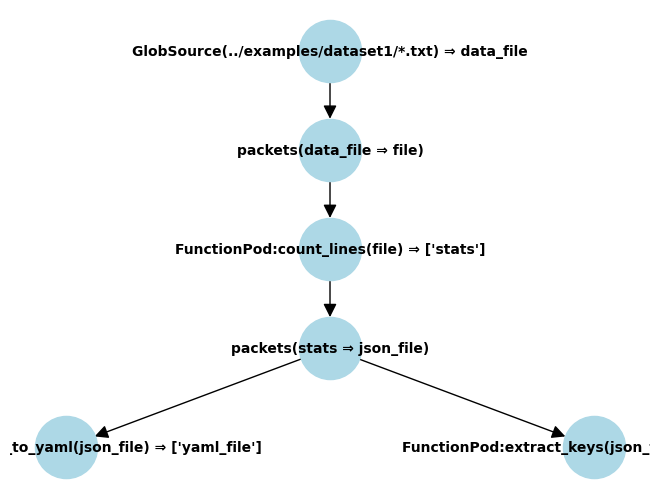

In [41]:
DEFAULT_TRACKER.draw_graph()

In [42]:
for node, in_degree in DEFAULT_TRACKER.generate_graph().degree:
    print(f"Node: {node}, In-Degree: {in_degree}")
    break

Node: Invocation(GlobSource(../examples/dataset1/*.txt) ⇒ data_file, ID:7805336534710128524), In-Degree: 1


In [43]:
for node in DEFAULT_TRACKER.generate_graph().nodes:
    print(f"Node: {node}")
    break

Node: Invocation(GlobSource(../examples/dataset1/*.txt) ⇒ data_file, ID:7805336534710128524)


In [44]:
for node in DEFAULT_TRACKER.generate_graph().edges:
    print(f"Edge: {node}")

Edge: (Invocation(GlobSource(../examples/dataset1/*.txt) ⇒ data_file, ID:7805336534710128524), Invocation(packets(data_file ⇒ file), ID:7295214722844861365))
Edge: (Invocation(packets(data_file ⇒ file), ID:7295214722844861365), Invocation(FunctionPod:count_lines(file) ⇒ ['stats'], ID:319846937452480905))
Edge: (Invocation(FunctionPod:count_lines(file) ⇒ ['stats'], ID:319846937452480905), Invocation(packets(stats ⇒ json_file), ID:1226137344290369747))
Edge: (Invocation(packets(stats ⇒ json_file), ID:1226137344290369747), Invocation(FunctionPod:json_to_yaml(json_file) ⇒ ['yaml_file'], ID:414233198714605481))
Edge: (Invocation(packets(stats ⇒ json_file), ID:1226137344290369747), Invocation(FunctionPod:extract_keys(json_file) ⇒ ['key_info'], ID:2006476212990005541))


In [45]:
node

(Invocation(packets(stats ⇒ json_file), ID:1226137344290369747),
 Invocation(FunctionPod:extract_keys(json_file) ⇒ ['key_info'], ID:2006476212990005541))

In [46]:
import networkx as nx

# Create a directed graph
G = nx.DiGraph()
G.add_edges_from([(1, 2), (1, 3), (3, 4)])

# Find root nodes (nodes with in-degree = 0)
root_nodes = [node for node, in_degree in G.in_degree() if in_degree == 0]
print("Root nodes:", root_nodes)

Root nodes: [1]


In [47]:
[(node, in_degree) for node, in_degree in G.in_degree()]

[(1, 0), (2, 1), (3, 1), (4, 1)]